# Clustering question tags

Here we'll have a short look at the question tags in this competition to see whether we can find some useful clustering.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import networkx as nx
import networkx.algorithms.community as nxcom

RSEED = 42

Just loading the <code>questions</code> dataframe here and turning the string-formatted lists of question tags into numpy arrays.

In [2]:
# load question dataframe
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
# fix one row with an empty tag list which gets interpreted as float
inv_rows = questions[questions['tags'].apply(type) == float].index
questions.at[inv_rows, 'tags'] = ''
# split tag string into list of ints
questions['tags'] = questions['tags'].apply(lambda x: np.array(x.split()).astype(int))

In [3]:
questions.sample(5)

,question_id,bundle_id,correct_answer,part,tags
6710,6710,6709,1,6,[1]
442,442,442,3,2,"[143, 20, 38, 29]"
9436,9436,9436,0,5,[1]
10476,10476,10476,2,1,"[131, 101, 92]"
9742,9742,9742,1,5,[1]


Forming a list of all available tags.

In [4]:
all_tags = np.unique(np.concatenate(questions['tags'].values))
all_tags

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Now we build a graph <code>G</code> using the <code>networkx</code> module. Each known tag is associated with a node in the graph, and connections between nodes ("edges") indicate tags occurring together. Each edge carries a weight, which we here define as the number of questions in which the two adjacent tags (nodes) occurred together.

In [5]:
def add_edge_weight(head, tail):
    try:
        weight = G[head][tail]['weight']
    except:
        G.add_edge(head, tail, weight=1)
    else:
        G[head][tail]['weight'] += 1

# initialize graph
G = nx.Graph()

# add all nodes (tags)
for t in all_tags:
    G.add_node(t)
    
# add all edges (tags occurring together)
for q in questions.index:
    tags = questions.loc[q, 'tags']
    for i in range(len(tags)-1):
        for j in range(i+1, len(tags)):
            add_edge_weight(tags[i], tags[j])

Now let's see what it looks like if we plot that... it's clear that there are some tags which occur very often, with many different other tags. If we look closely, there are also some tags which only occur alone (the have no edge attached to them).

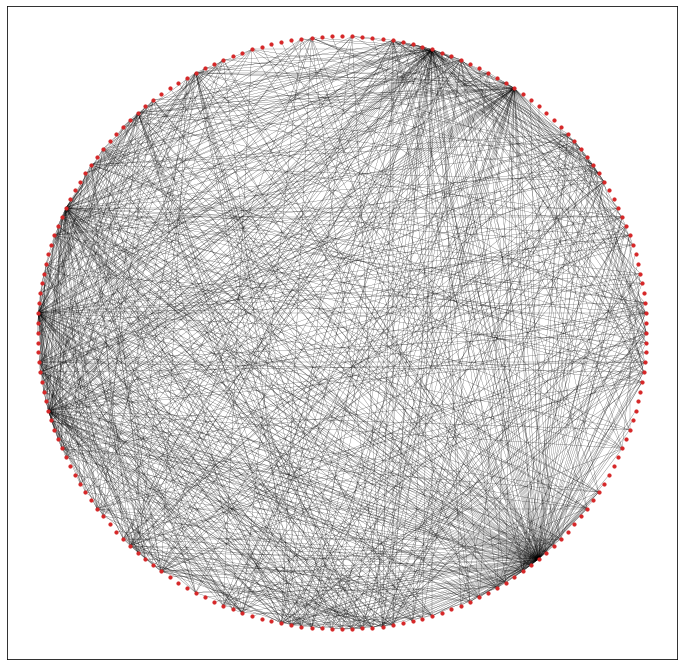

In [6]:
plt.figure(figsize=(12,12))
pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='tab:red')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.2)
plt.show()

Ok, so first let's find all the nodes without any edges and collect them in a list - these are all the tags which only show up alone, not together with any other tags. Then we remove them from the graph since we can't use them for any kind of clustering.

In [7]:
# find all nodes without edges
nodes_zero_edge = []
for n in nx.nodes(G):
    adjlist = list(G.adj[n])
    if len(adjlist) == 0:
        nodes_zero_edge.append(n)
print(np.sort(np.array(nodes_zero_edge)))
# remove from graph
for n in nodes_zero_edge:
    G.remove_node(n)

[  4  14  15  24  25  28  31  34  43  45  47  49  57  58  66  72  75  78
  85  86  95 108 112 115 124 125 133 134 151 152 156 166 167 168 174 175
 177 181 182]


Now plotting the remaining graph, we see that there are a lot of nodes which are only connected to one other node. I.e., these are tags which show up either by themselves or paired with one certain other tag. This "one certain other tag" appears to be the same for all of these (all single-edge nodes connect to the same node in the middle).

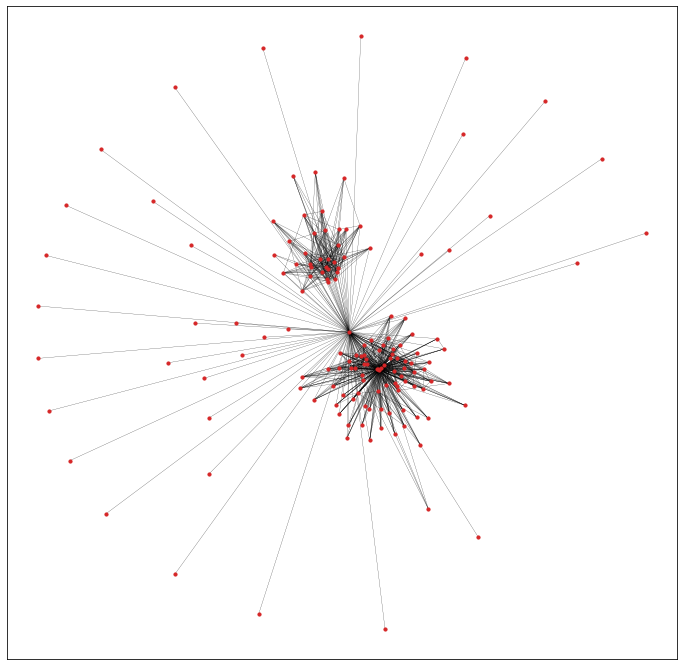

In [8]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, seed=RSEED)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='tab:red')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.2)
plt.show()

So let's find all of these single-edge nodes, save them in a list and print out what they are connected to and with which weight (i.e., how often they occur with this one other tag).

In [9]:
# find all nodes with a single edge
nodes_one_edge = []
for n in nx.nodes(G):
    if len(list(G.adj[n])) == 1:
        nodes_one_edge.append(n)
        
# print where all of these nodes connect to        
nodes_one_edge = np.sort(nodes_one_edge)
for n in nodes_one_edge:
    adjlist = list(G.adj[n])
    print(n, adjlist[0], G[n][adjlist[0]]['weight'])

1 162 9
7 162 2
8 162 13
23 162 1
26 162 1
27 162 41
33 162 1
44 162 1
48 162 1
52 162 2
53 162 21
54 162 1
55 162 4
60 162 1
64 162 1
65 162 1
73 162 13
79 162 3
80 162 1
89 162 1
91 162 4
96 162 5
109 162 6
116 162 1
123 162 1
127 162 1
128 162 1
132 162 1
147 162 12
159 162 2
170 162 1
172 162 1
173 162 4
179 162 6
180 162 2


All of these tags only show up in combination with tag 162 - seems to be some kind of meaningful tag. Let's take all of these single-edge tags out of the graph as well for now.

In [10]:
# remove all nodes with only a single edge
for n in np.sort(nodes_one_edge):
    G.remove_node(n)

Plotting what's left of the graph, we can see two well separated clusters which are connected only by - guess what - tag number 162.

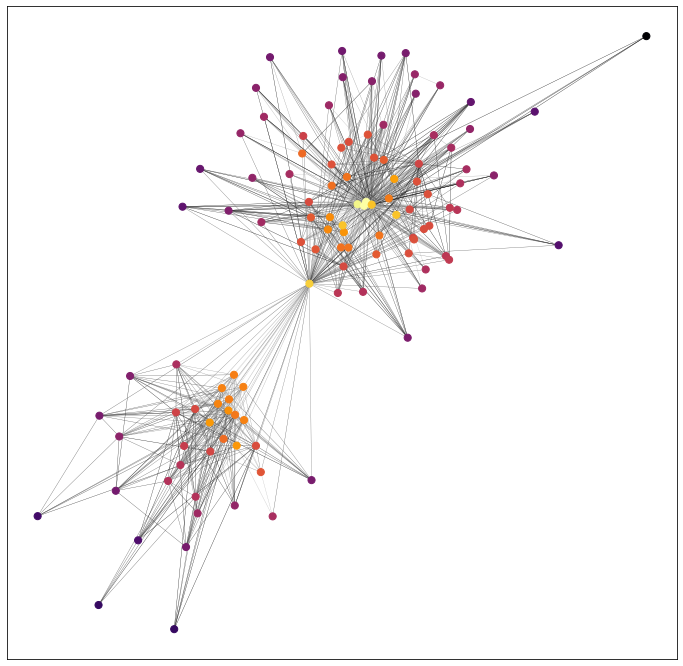

In [11]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, seed=RSEED)

nweights = []
for n in G.nodes():
    nweights.append(np.log10(np.sum([G.adj[n][x]['weight'] for x in G.adj[n]])))
eweights = np.log10([d['weight'] for (u, v, d) in G.edges(data=True)])

nx.draw_networkx_nodes(G, pos, node_size=50, node_color=nweights, cmap=plt.cm.inferno)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=eweights, edge_cmap=plt.cm.Greys_r, width=0.3)
plt.show()

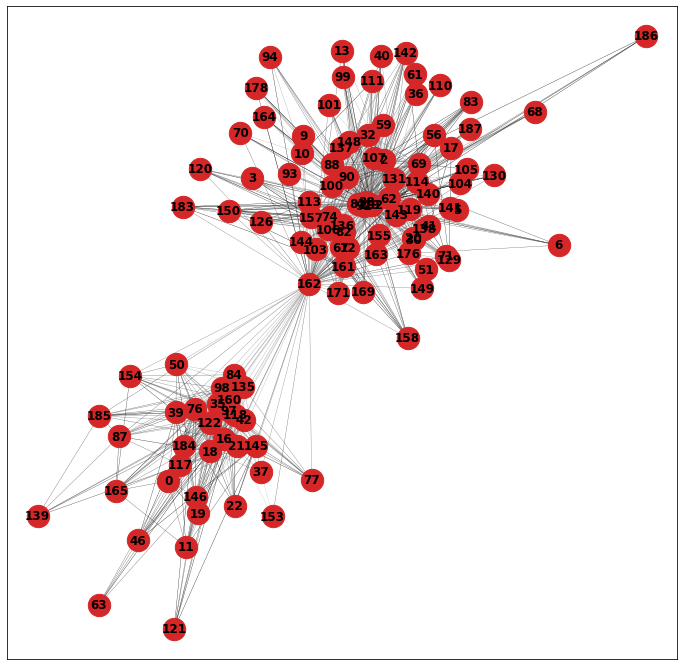

In [12]:
plt.figure(figsize=(12,12))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='tab:red')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=eweights, edge_cmap=plt.cm.Greys_r, width=0.3)
nx.draw_networkx_labels(G, pos, {n: str(n) for n in list(G.nodes())}, font_weight='bold', font_color='k')
plt.show()

So we run a community finding algorithm to separate the remaining nodes into the two clearly visible clusters. Plotting them in red/blue just as a sanity check, no surprises here.

In [13]:
cs = sorted(nxcom.asyn_lpa_communities(G, weight='weight'), key=len, reverse=True)
print('Found', len(cs), 'communities')

Found 2 communities


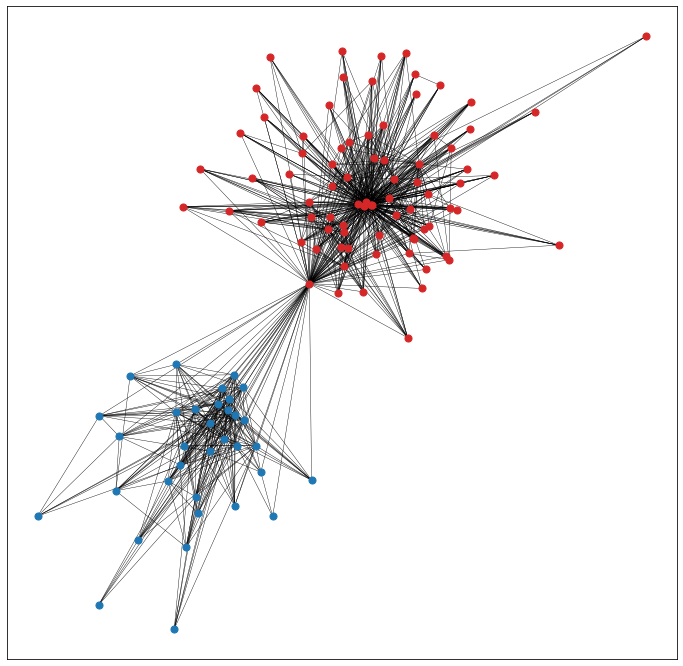

In [14]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, seed=RSEED)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='tab:red', nodelist=cs[0])
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='tab:blue', nodelist=cs[1])
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.4)

So quick inventory check - what have we got by now:

* A list with all tags which only occur by themselves (<code>c0</code> / community 0)
* A list with all tags which only occur by themselves or together with tag 162 (<code>c1</code> / community 1)
* Two well-separated clusters of the remaining tags (<code>c2</code> and <code>c3</code> / communities 2 and 3)

The code below just checks for duplicates to make sure we didn't mess up anything, and creates a dictionary with tags as keys and the tag's associated communities as values.

In [15]:
# make array of nodes for each community
c0 = np.sort(nodes_zero_edge)
c1 = np.sort(nodes_one_edge)
c2 = np.sort(list(cs[0]))
c3 = np.sort(list(cs[1]))

# check for duplicates
comb = np.array([])
for clist in [c0,c1,c2,c3]:
    comb = np.append(comb, clist)
unq, cnt = np.unique(comb, return_counts=True)
print('Duplicate entries found' if np.any(cnt>1) else 'No duplicates found')

# create dict assigning community index to each tag
cmnts = {}
for n, clist in enumerate([c0,c1,c2,c3]):
    for i in clist:
        cmnts[i] = n
print('Dict created')

No duplicates found
Dict created


Using this dict we can fill a new column in the <code>questions</code> dataframe which assigns a community to each question, basically going by which community most of the tags belong into. Looking at the graphs above, for each question all tags apart from tag 162 should be in the same community anyway. To avoid unclarities if we have two tags and one of them is tag 162, we for now just ignore tag 162 if it is not the only tag present.

In [16]:
questions['community'] = -1
for iii in questions.index:
    tags = questions.loc[iii, 'tags']
    # ignore tag 162 if there's more than one tag, it is connected to all clusters anyway
    if len(tags) > 1:
        tags = tags[tags != 162]
    clist = np.array([cmnts[tag] if tag in cmnts.keys() else int(4) for tag in tags])
    if len(clist):
        c = np.bincount(clist).argmax()
    else:
        c = 4
    questions.loc[iii, 'community'] = c

In [17]:
questions.sample(5)

,question_id,bundle_id,correct_answer,part,tags,community
6697,6697,6697,1,6,[27],1
215,215,215,3,2,"[129, 143, 30, 92, 29]",2
12615,12615,12615,0,1,"[131, 104, 38]",2
10430,10430,10430,3,1,"[9, 10, 92]",2
8112,8112,8109,0,7,"[84, 118, 42, 135]",3


Quickly checking out how many questions end up in each community. The larger one of the two clusters has the most questions, followed by the group of tags which only show up by themselves or together with tag 162. Tags exclusively showing up alone have much fewer questions, closely followed by the smaller of the two tag clusters. One question has no community assigned to it (remember, we had to sort that one out manually at the beginning of this kernel).

In [18]:
questions[['question_id', 'community']].groupby(by='community').count()

,question_id
community,
0,1349
1,5373
2,5640
3,1160
4,1


Lastly, we save the column holding each question's community together with the <code>question_id</code> to a csv file for further use.

In [19]:
questions['community'].to_csv('question_cmnts.csv')

Leave a comment if you have any ideas or questions on this topic and upvote if you liked this quick overview!